In [1]:
import numpy
from matplotlib import pyplot
from scipy import sparse
import scipy.sparse.linalg

In [19]:
def make_lattice(xsidelen=2, ysidelen=2):
    x = numpy.arange(xsidelen)
    y = numpy.arange(ysidelen)
    n = numpy.arange(4)
    X, Y, N = numpy.meshgrid(x, y, n)

    INDX = Y*len(x)*len(n) + X*len(n) + N
    SQR_BONDS = Y*len(x)*len(n) + X*len(n) + (N + 1)%len(n)

    edges = [((a, b), 1 if a%len(n) == 0 and b%len(n) == 1 else -1) 
             for a,b in zip(INDX.flatten(), SQR_BONDS.flatten())]
    
    for (sx, sy, sn) in zip(X.flatten(), Y.flatten(), N.flatten()):
        if sn == 1:
            a = sy*len(x)*len(n) + sx*len(n) + 1
            b = sy*len(x)*len(n) + ((sx+1)%len(x))*len(n) + 3
            edges.append(((a,b), -1))
        if sn == 0:
            a = sy*len(x)*len(n) + sx*len(n) + 0
            b = ((sy+1)%len(y))*len(x)*len(n) + sx*len(n) + 2
            edges.append(((a,b), -1))
    
    return edges

def get_cart(a, xsidelen=2, ysidelen=2, inner_size=0.1):
    y = a//(xsidelen*4)
    x = (a//4)%ysidelen
    rel = a % 4
    if rel == 0:
        return (x, y+inner_size)
    if rel == 1:
        return (x+inner_size, y)
    if rel == 2:
        return (x, y-inner_size)
    if rel == 3:
        return (x-inner_size, y)
    
def make_ham_and_spin(nvars, edges, transverse):
    ham = sparse.dok_matrix((2**nvars,2**nvars), dtype=numpy.float64)
    
    for i in range(2**nvars):
        state = [(i >> j) & 1 for j in range(nvars)]
        h = 0.0
        for (vara, varb), j in edges:
            if state[vara] == state[varb]:
                h += j
            else:
                h -= j

        ham[i,i] += h
        
        for j in range(nvars):
            i_flip = i ^ (1 << j)
            ham[i, i_flip] = ham[i,i_flip] + transverse
    return ham.tocsc()

def draw_lattice(edges, spins=None):
    for (a, b), j in edges:
        ax, ay = get_cart(a, 2, 2)
        bx, by = get_cart(b, 2, 2)
    
        if abs(ax - bx) >= 1.0 or abs(ay - by) >= 1.0:
            alpha = 0.1
        else:
            alpha = 1.0
            
        if spins is None:
            if j > 0:
                c = 'r'
            else:
                c = 'b'
        else:
            if spins[a]*spins[b]*j > 0:
                c = 'r'
            else:
                c = 'b'
            if spins[a] > 0:
                pyplot.scatter([ax],[ay], c='r')
            elif spins[a] < 0:
                pyplot.scatter([ax],[ay], c='b')
            if spins[b] > 0:
                pyplot.scatter([bx],[by], c='r')
            elif spins[b] < 0:
                pyplot.scatter([bx],[by], c='b')
                
        pyplot.plot([ax, bx], [ay, by], c=c, alpha=alpha)
        
    pyplot.show()

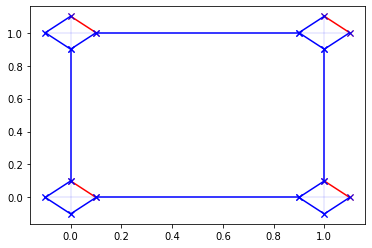

In [3]:
edges = make_lattice(2, 2)
draw_lattice(edges)

Plaquette lives on an oddly shaped unit cell

In [4]:
coord_edges = [
    ((0,0,0), (0,0,1), 1.0),
    ((0,0,1), (0,0,2), -1.0),
    ((0,0,2), (0,0,3), -1.0),
    ((0,0,3), (0,0,0), -1.0),
    
    ((1,0,0), (1,0,1), 1.0),
    ((1,0,1), (1,0,2), -1.0),
    ((1,0,2), (1,0,3), -1.0),
    ((1,0,3), (1,0,0), -1.0),
    
    ((1,1,0), (1,1,1), 1.0),
    ((1,1,1), (1,1,2), -1.0),
    ((1,1,2), (1,1,3), -1.0),
    ((1,1,3), (1,1,0), -1.0),
    
    ((2,1,0), (2,1,1), 1.0),
    ((2,1,1), (2,1,2), -1.0),
    ((2,1,2), (2,1,3), -1.0),
    ((2,1,3), (2,1,0), -1.0),
    
    # Inter-connections
    ((0,0,1), (1,0,3), -1.0),
    ((1,0,2), (1,1,0), -1.0),
    ((1,1,1), (2,1,3), -1.0),
    
    # Now the periodic boundaries
    ((0,0,0), (2,1,2), -1.0),
    ((0,0,2), (1,0,0), -1.0),
    ((0,0,3), (2,1,1), -1.0),
    
    ((1,0,1), (1,1,3), -1.0),
    
    ((1,1,2), (2,1,0), -1.0)
]

var_pos = set(k for ks in coord_edges for k in [ks[0], ks[1]])
var_lookup = {k: i for i, k in enumerate(sorted(var_pos))}
plaquette_edges = [
    ((var_lookup[ka], var_lookup[kb]), j) for (ka, kb, j) in coord_edges
]

In [5]:
def convert_state(state):
    acc = 0
    for i,s in enumerate(state):
        if s == 1:
            acc += 1 << i
    return acc

def make_state(a, b):
    return [
        1, 1, 1, a, 
        1, -1, -1, a,
        -1, b, -1, -1,
        -1, 1, 1, b
    ]

def make_plaquette():
    nvars = 16

    states = [make_state(a,b) for a in [1,-1] for b in [1,-1]]
    state_nums = [convert_state(state) for state in states]
    state = numpy.zeros((2**nvars,))
    for s in state_nums:
        state[s] = 1/numpy.sqrt(len(state_nums))
    return state

def make_columnar():
    nvars = 16
    state = numpy.zeros((2**nvars,))
    state[convert_state(make_state(1, -1))] = 1
    return state

plaquette_state = make_plaquette()
columnar_state = make_columnar()

In [50]:
gammas = numpy.linspace(0, 3, 10)
plaquette_energies = []
columnar_energies = []
for gamma in gammas:
    h = make_ham_and_spin(len(var_lookup), plaquette_edges, gamma)
    plaquette_energies.append(plaquette_state.T @ (h @ plaquette_state))
    columnar_energies.append(columnar_state.T @ (h @ columnar_state))

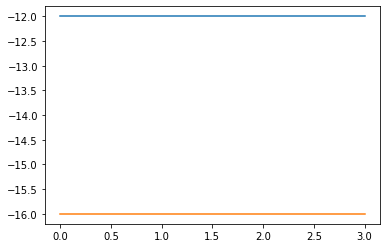

In [51]:
pyplot.plot(gammas, plaquette_energies)
pyplot.plot(gammas, columnar_energies)
pyplot.show()

In [ ]:
h = make_ham_and_spin(len(var_lookup), plaquette_edges, 0.1)

In [30]:
min_e, min_v = scipy.sparse.linalg.eigsh(h, k=36, which='SA')
min_e

array([-16.08424781, -16.0819822 , -16.0819822 , -16.07717775,
       -16.07277286, -16.06704381, -16.06704381, -16.06704311,
       -16.06704311, -16.0646573 , -16.0646573 , -16.0533796 ,
       -16.05327147, -16.05327145, -16.05327145, -16.05304868,
       -16.05304867, -16.05304867, -16.05300659, -16.05300659,
       -16.05300659, -16.05300659, -16.05299419, -16.05298512,
       -16.05292864, -16.04132083, -16.04132083, -16.03909631,
       -16.03909631, -16.03909563, -16.03909563, -16.03324935,
       -16.02877187, -16.02401151, -16.02401151, -16.02175661])

In [36]:
for i in range(min_v.shape[-1]):
    mi = numpy.argmax(abs(min_v[:,i]))
    close_maxes = abs(abs(min_v[:,i]) - abs(min_v[mi,i])) < 1e-6
    states = numpy.nonzero(close_maxes)[0]
    state_args = numpy.angle(min_v[:,i])[states] / numpy.pi
    print("{}\te^i{}pi".format(states, state_args))

[ 7650  8670 56865 57885]	e^i[1. 1. 1. 1.]pi
[ 2550 62985]	e^i[0. 1.]pi
[24735 40800]	e^i[1. 0.]pi
[ 7650  8670 56865 57885]	e^i[0. 1. 1. 0.]pi
[ 2550 24735 40800 62985]	e^i[1. 0. 0. 1.]pi
[ 2400 24585 40950 63135]	e^i[0. 0. 1. 1.]pi
[  150 27135 38400 65385]	e^i[0. 1. 0. 1.]pi
[  150 27135 38400 65385]	e^i[1. 0. 0. 1.]pi
[ 2400 24585 40950 63135]	e^i[0. 1. 1. 0.]pi
[ 2550 62985]	e^i[1. 0.]pi
[24735 40800]	e^i[1. 0.]pi
[    0 26985 38550 65535]	e^i[0. 0. 0. 0.]pi
[    0 26985 38550 65535]	e^i[0. 1. 1. 0.]pi
[26985 38550]	e^i[0. 1.]pi
[    0 65535]	e^i[0. 1.]pi
[ 7650  8670 56865]	e^i[0. 1. 1.]pi
[ 8670 56865]	e^i[0. 1.]pi
[57885]	e^i[1.]pi
[24605 57865 58015 63005]	e^i[1. 0. 0. 1.]pi
[  470  8350 10750 25055]	e^i[0. 1. 1. 0.]pi
[ 2530  7520  7670 40930]	e^i[0. 1. 1. 0.]pi
[40480 54785 57185 65065]	e^i[1. 0. 0. 1.]pi
[    0   150  2400  2550 24585 24735 26985 27135 38400 38550 40800 40950
 62985 63135 65385 65535]	e^i[0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0.]pi
[  470  2530  7520

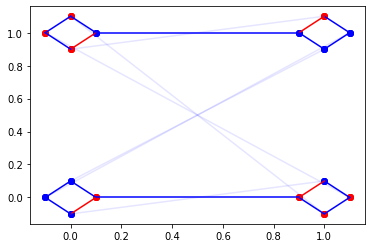

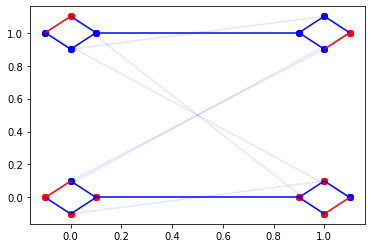

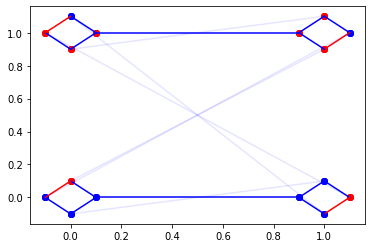

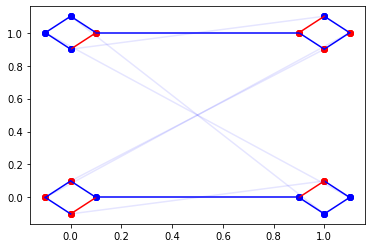

In [34]:
i_to_check = 0
mi = numpy.argmax(abs(min_v[:,i_to_check]))
close_maxes = abs(abs(min_v[:,i_to_check]) - abs(min_v[mi,i_to_check])) < 1e-6

for example_state in numpy.nonzero(close_maxes)[0]:
    example_state = [example_state >> i & 1 for i in range(16)]
    example_state = [1 if i == 1 else -1 for i in example_state]
    draw_lattice(plaquette_edges, example_state)

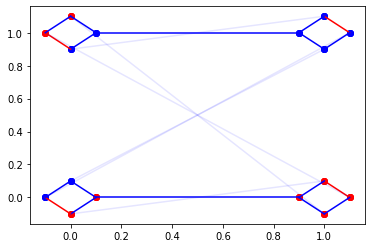

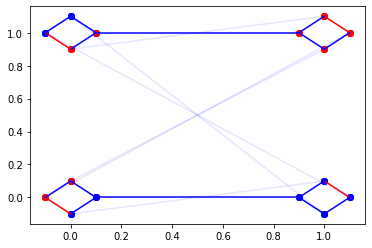

In [33]:
i_to_check = 1
mi = numpy.argmax(abs(min_v[:,i_to_check]))
close_maxes = abs(abs(min_v[:,i_to_check]) - abs(min_v[mi,i_to_check])) < 1e-6

for example_state in numpy.nonzero(close_maxes)[0]:
    example_state = [example_state >> i & 1 for i in range(16)]
    example_state = [1 if i == 1 else -1 for i in example_state]
    draw_lattice(plaquette_edges, example_state)